## Le but de notre projet est d'implémenter le ridge de façon paralléliser 

Plan prévu :

- Ecrire une fonction qui génère les données (comme en opti)
- Implémenter une première version d'optimisation du ridge (non parallélisée)
- Essayer de faire une fonction plus optimisée avec cython par exemple
- Ecrire un peu de théorie sur le ridge para 
- utilisation de MPI allreduce ou OpenMP (les trucs dans le genre)
- implémentation de l'algo 
- Comparaison des algos + plots

In [2]:
#On importe les librairies

import numpy as np
import matplotlib.pyplot as plt

## 1) Générer des données sparse pour une régresssion lineaire

In [3]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n_samples, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n_samples)
    noise = std * randn(n_samples)
    b = A.dot(x) + noise
    return A, b

In [4]:
d = 50              #nb features
n = 10000           #nb samples
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.) # Valeur des vrais paramètres 

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.5)
print('La dimension de A est :', A.shape ,'\n La dimension de b est :', b.shape)

La dimension de A est : (10000, 50) 
 La dimension de b est : (10000,)


Text(0.5, 1.0, 'Valeur des vrais coefficients des features')

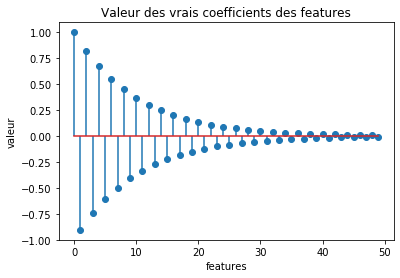

In [5]:
plt.stem(x_model_truth, use_line_collection=True)
plt.xlabel('features')
plt.ylabel('valeur')
plt.title('Valeur des vrais coefficients des features')

## Implémentation d'un algo d'optimisation pour résoudre ce problème 

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)

In [6]:
from numpy.linalg import norm

In [7]:
#Gradient en i
def grad_i_linreg(i, x, A, b, lbda, n_samples):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x

### Ecriture de l'algorithme SGD

In [8]:
lbda = 0.1

In [9]:
n_epochs = 100 # here corresponds to the number of epochs

# generate indices of random samples
iis = np.random.randint(0, n, n * n_epochs)

In [10]:
len(iis)

1000000

In [11]:
def sgd(x_init, iis, n_iter, step=0.1, store_every =n, args=(A, b, lbda, n)):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x -= step/np.sqrt(idx + 1) * grad_i_linreg(i, x, *args)
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [12]:
#lipshitz constant 

L = lipschitz_linreg( A, b, lbda, n_samples=A.shape[0])

Mesurons le temps temps d'execution de l'algorithme

In [13]:
import time

In [14]:
debut = time.time()
w_solu, w_list = sgd(x_init=np.ones(len(x_model_truth)), iis=iis, n_iter=n*n_epochs, step=0.01)
fin = time.time()
print(fin-debut,'s')

12.125131130218506 s


Text(0.5, 1.0, 'Erreur absolue par coefficient')

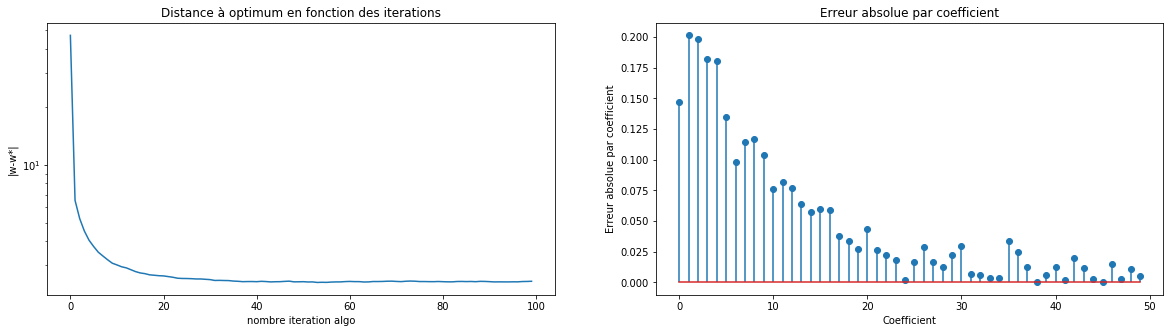

In [15]:
# On plot la 
list_erreur_temps = [sum(abs(vec - x_model_truth)) for vec in w_list]


plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.semilogy(list_erreur_temps)
plt.xlabel('nombre iteration algo')
plt.ylabel('|w-w*|')
plt.title('Distance à optimum en fonction des iterations')


plt.subplot(1,2,2)
plt.stem(abs(w_solu - x_model_truth), use_line_collection=True)
plt.xlabel('Coefficient')
plt.ylabel('Erreur absolue par coefficient')
plt.title('Erreur absolue par coefficient')



In [16]:
print('erreur absolue entre deux points est de ', sum(abs(w_solu - x_model_truth)) / len(w_solu)) 

erreur absolue entre deux points est de  0.04951581648855678


### Plot quand le nombre d'individu augmente

In [17]:
#On Ecrit une fonction qui simule des données pour différents nombres d'individus

def simulateur_donnees(n,d):

    idx = np.arange(d)
    x_model_truth = (-1)**idx * np.exp(-idx / 10.) # Valeur des vrais paramètres 
    A, b = simu_linreg(x_model_truth, n, std=1., corr=0.5)
    return A, b


In [37]:
#Simulons plusieurs jeux de données où la tailel de nombre de sample varie

list_A = list()
list_b = list()

n_sample = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

for sample in n_sample:
    r1, r2 = simulateur_donnees(n=int(sample), d=50)
    list_A.append(r1)
    list_b.append(r2)

In [38]:
#On peut aussi plot le temps d'executions pour différents n
list_temps = list()
list_w_solu = list()

for ii in range(len(n_sample)):
    
    print(ii, 'eme itération')
    n = n_sample[ii]
    A, b = list_A[ii], list_b[ii]
    iis = np.random.randint(0, int(n), int(n * n_epochs))
    
    debut = time.time()
    w_sol, _ = sgd(x_init=np.ones(len(x_model_truth)), iis=iis, n_iter=int(n*n_epochs), step=0.05, 
               args=(A, b, lbda, n))
    list_w_solu.append(w_sol)
    fin = time.time()
    list_temps.append(fin-debut)

0 eme itération
1 eme itération
2 eme itération
3 eme itération
4 eme itération
5 eme itération


Text(0.5, 1.0, 'erreur absolue moyenne en fonction du nombre individu')

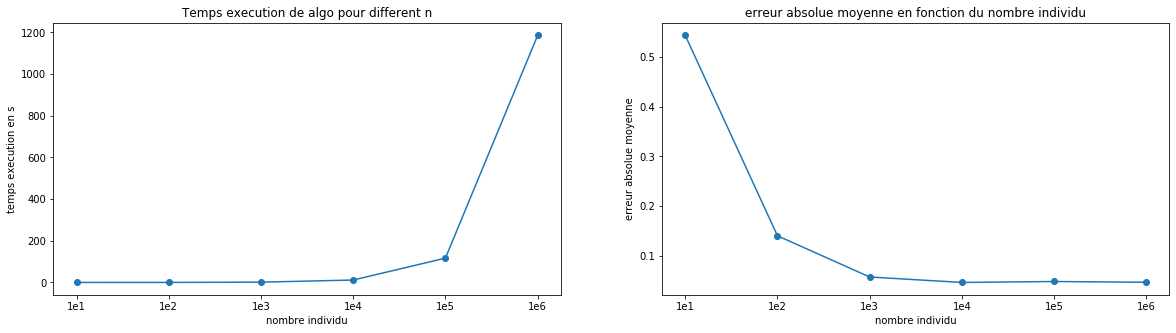

In [41]:
#Plot
n_sample_string = ['1e1', '1e2', '1e3', '1e4', '1e5', '1e6']
list_precision = [sum(abs(vec_solu - x_model_truth)) / len(vec_solu) for vec_solu in list_w_solu]

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(n_sample_string, list_temps, 'o-')
plt.xlabel('nombre individu')
plt.ylabel('temps execution en s')
plt.title('Temps execution de algo pour different n')

plt.subplot(1,2,2)
plt.plot(n_sample_string, list_precision, 'o-')
plt.xlabel('nombre individu')
plt.ylabel('erreur absolue moyenne')
plt.title('erreur absolue moyenne en fonction du nombre individu')


## Essayons de paralléliser notre stochastic gradient descent

Par exemple le mec fait ça ici (https://github.com/angadgill/Parallel-SGD)